# Analysis of Italy's CO2 emissions from 1990 to 2023
This notebook aims to anayze various elements and trends related to CO2 emissions in Italy.
WIP

In [48]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

plt.style.use("ggplot")

path_emissions = "D:/Python projects and excercises/co2-emissions-italy/data_processed/co2_emissions_all_years.csv"
df = pd.read_csv(path_emissions)
df["CO2 emissions (kt)"] = pd.to_numeric(df["CO2 emissions (kt)"], errors="coerce")
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")

path_policies = "D:/Python projects and excercises/co2-emissions-italy/data_processed/policies.csv"
policies = pd.read_csv(path_policies)
policies["Year"] = pd.to_numeric(policies["Year"], errors="coerce")

#print(df.dtypes)
#print(policies.dtypes)


## CO2 Total emissions by year (1990-2023)


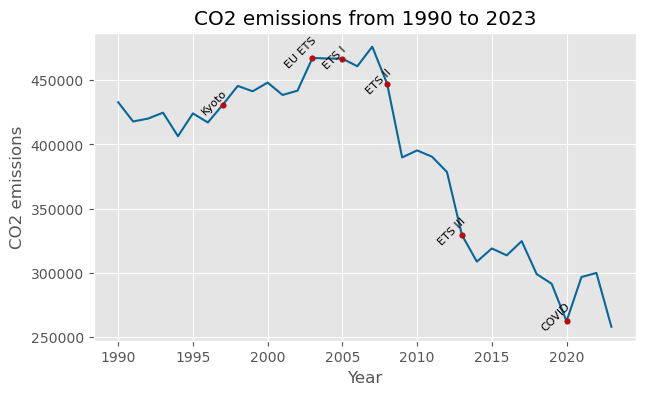

In [49]:
df_tot = df[df["Category"] == "Total national emissions and removals"]
x = df_tot["Year"]
y = df_tot["CO2 emissions (kt)"]

plt.figure(figsize=(7,4))
plt.plot(x,y, color="#06689A", label="Emissions")
plt.xlabel("Year")
plt.ylabel("CO2 emissions")
plt.title("CO2 emissions from 1990 to 2023")

labels_sel = {"Kyoto", "EU ETS", "ETS I", "ETS II", "ETS III", "COVID"}
pol_subset = policies[policies["ShortLabel"].isin(labels_sel)]


for i,row in pol_subset.iterrows():
    year: int = int(row["Year"])
    policy = row["ShortLabel"]

    if year in df_tot["Year"].values:
        year_emissions = df_tot.loc[df_tot["Year"] == year, "CO2 emissions (kt)"].iloc[0]
        plt.scatter(year, year_emissions, color="#BC0808", zorder=5, s=15)
        plt.annotate(policy, (year, year_emissions), fontsize=8, rotation=45, ha="right", textcoords="offset points", xytext=(4,-7))


plt.show()

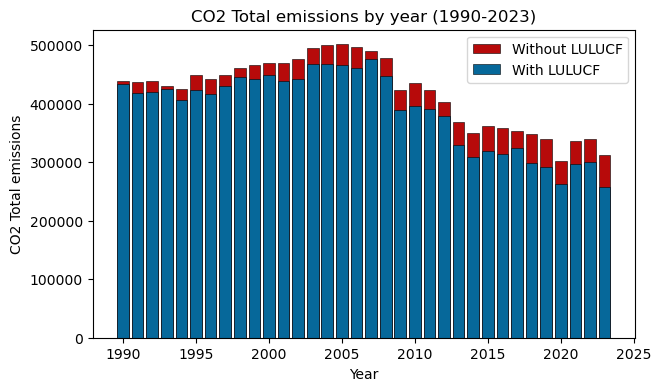

In [3]:
df_tot = df[df["Category"] == "Total national emissions and removals"]
df_nolulucf = df[df["Category"] == "Emissions without LULUCF"]

x = df_tot["Year"]
y = df_tot["CO2 emissions (kt)"]
y2 = df_nolulucf["CO2 emissions (kt)"]

plt.figure(figsize=(7,4))
plt.bar(x,y2, color = "#B70A0A", label="Without LULUCF", edgecolor="black", linewidth=0.4)
plt.bar(x,y, color="#06689A", label="With LULUCF", edgecolor="black", linewidth=0.4)

plt.xlabel("Year")
plt.ylabel("CO2 Total emissions")
plt.title("CO2 Total emissions by year (1990-2023)")
plt.legend()
plt.show()

Aggiungere percentuale di recupero con LULUCF, se possibile date di leggi importanti a cui è conseguita riduzione CO2